In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd 
from PIL import Image
import os   
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor

## Part 1: A Practical Introduction to Bayesian Hyperparameter Optimization

### Bayes Theorem 
Bayes theorem defines the probability of an event $A$ conditioned on an event $B$ as follows.

$$ P(A|B) = \frac{P(B | A) \ast P(A)}{P(B)} $$

Using this theorem, we can optimize a complicated function by creating an easier to calculate surrogate based on a probability distribution created by sampling our original function. Then we continue to take samples that are most likely to improve our estimate of the best "score", making our surrogates estimations more and more accurate. This process is called **Bayesian Optimization**. Let's get started by defining an "objective" function (score function) and a basic Gaussian Process model below.

In [26]:
# Define an expensive objective function that we want to approximate
def objective(x, noise=0.5):
    random_noise = np.random.normal(scale=noise)
    return (math.sin(3* math.pi * x) + x) + random_noise

# Generate initial samples with noise
X = np.random.random(100).reshape(-1, 1)
y = np.array([objective(x) for x in X]).reshape(-1, 1)

# Instantiate the model
model = GaussianProcessRegressor()
model.fit(X, y)

/var/folders/f1/tq0d32ns75nf17h55y1swtdh0000gn/T/ipykernel_76067/1844835319.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (math.sin(3* math.pi * x) + x) + random_noise


GaussianProcessRegressor()

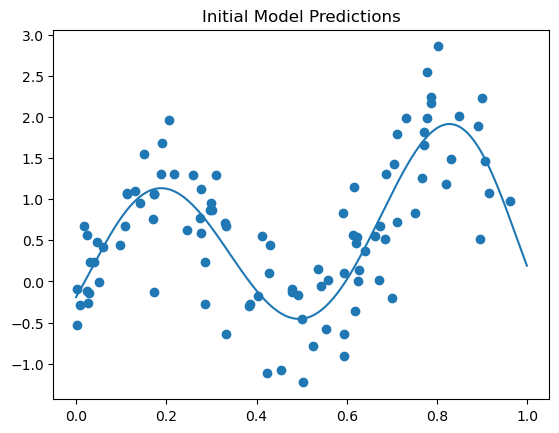

In [27]:
# Define a visualization function that plots prediction vs. actual
def visualize(X, y):
    plt.scatter(X, y)
    Xsamples = np.arange(0, 1, 0.001).reshape(-1, 1)
    ysamples = model.predict(Xsamples)
    plt.title("Initial Model Predictions")
    plt.plot(Xsamples, ysamples)
    plt.show()

# Visualize the initial data
visualize(X, y)

### Acquisition Function
Now we have the problem of exploration vs exploitation, often observed in reinforcement learning problems such as bandit optimization. How can we choose points such that we optimize the balance between exploring unknown points that could potentially be better than what we have and verifying our current highest scores, especially in a non-deterministic sample space? This is where acquisition functions come in, they use various heuristic methods to determine what points are most likely to improve the model's predictions. Some of these methods include:

- Probability of Improvement
- Expected Improvement (EI): This function not only considers the probability of improvement but also takes into account the potential magnitude of improvement. It refines the approach by evaluating how much better a possible outcome could be.
- Entropy Search: This method selects points that will provide the most information gain, effectively balancing exploration across the sample space. It can be likened to traversing an extensive landscape of hills and valleys, seeking areas that offer the most insight.
- Upper Confidence Bound (UCB): UCB uses a balance factor to weigh between exploration and exploitation. It adjusts its strategy based on a confidence interval around predictions, allowing for a dynamic balance between trying new points and exploiting known high-value areas.

The technical workings of Entropy Search are a little complex and beyond the scope of the class, but let's talk about how we could implement the other three functions. 

### Probability of Improvement
Probability of Improvement (PI): This is the simplest acquisition function. It focuses on the probability that a given point will improve upon the current best-known value. However, it often gets stuck in local optima due to its simplicity.

In [ ]:
# Define the acquisition function to calculate probability of improvement
def probability_of_improvement(X, Xsamples, xi=0.01):
    # Determine the best score from the surrogate model so far
    yhat = model.predict(X)
    best_score = max(yhat)

    # Calculate mean and standard deviation using the surrogate model
    mu, std = model.predict(Xsamples, return_std=True)

    # Compute probability of improvement
    probabilities = norm.cdf((mu - best_score - xi) / (std + 1E-9))
    return probabilities

from scipy.stats import norm

def expected_improvement(X, Xsamples, model, xi=0.01):
    yhat = model.predict(X)
    best_score = max(yhat)

    mu, std = model.predict(Xsamples, return_std=True)
    with np.errstate(divide='warn'):
        imp = mu - best_score - xi
        Z = imp / std
        ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
        ei[std == 0.0] = 0.0
    return ei

def upper_confidence_bound(Xsamples, model, beta=2.0):
    mu, std = model.predict(Xsamples, return_std=True)
    ucb = mu + beta * std
    return ucb


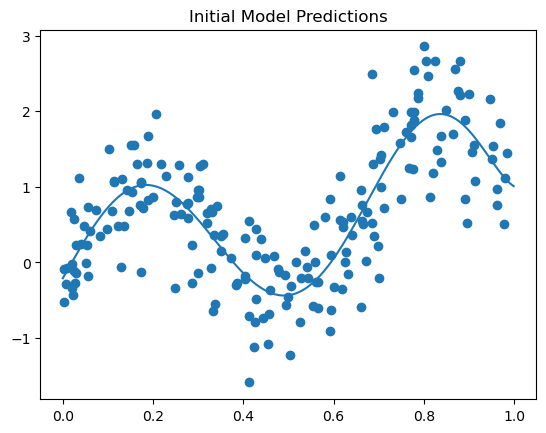

Best Result: x=0.801, y=2.855


/var/folders/f1/tq0d32ns75nf17h55y1swtdh0000gn/T/ipykernel_76067/2296189843.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Best Result: x=%.3f, y=%.3f' % (X[best_index], y[best_index]))


In [29]:
# Run optimization loop to improve sampling points iteratively
for i in range(100):
    next_sample = optimize_acquisition(X, y)
    actual_value = objective(next_sample)
    
    # Update dataset with new sample point and observation
    X = np.vstack((X, [[next_sample]]))
    y = np.vstack((y, [[actual_value]]))
    
    # Re-fit model with updated data
    model.fit(X, y)

# Final plot of all samples and surrogate model predictions
visualize(X, y)

# Identify and print the best result found during optimization
best_index = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[best_index], y[best_index]))

Now let's see an example of using this technique to optimize the hyperparameters of a Multi-Layer Perceptron used to classify Pokémon types.

## Part 2: A Demonstration of Bayesian Hyperparameter Optimization

### Load the Data

In [30]:
# Create a load data function
def load_images(folder_name):
    names = []
    images = []
    for filename in os.listdir(folder_name):
        try:
            filepath = os.path.join(folder_name, filename)
            img = Image.open(filepath)
            img = img.resize((64, 64))
            img = np.asarray(img).flatten()
            names.append(filename.split(".")[0])
            images.append(img)
        except Exception as error:
            print(f"Error loading {folder_name}: {error}")
    return dict(zip(names, images)) # Returns a dictionary of names to image data

In [50]:
# Clean the data
image_data = "images"
pokemon_data = pd.read_csv("pokemon.csv")
names_to_images = load_images(image_data)

# Add image data column using dictionary and the "Name" column in the dataframe
pokemon_data['Image_Data'] = pokemon_data['Name'].map(names_to_images)
pokemon_data = pokemon_data.loc[lambda x: x.Type2.isnull()]
pokemon_data.drop('Type2', axis=1, inplace=True)  # Remove multi-type Pokémon
pokemon_data.drop('Evolution', axis=1, inplace=True)

# Filter out types with less than 30 counts
type_counts = pokemon_data['Type1'].value_counts()
valid_types = type_counts[type_counts >= 30].index
pokemon_data = pokemon_data[pokemon_data['Type1'].isin(valid_types)]

# Encode the type variable
pokemon_data['Type1'] = pokemon_data['Type1'].astype('category')
pokemon_data['Type'] = pokemon_data['Type1'].cat.codes
features = pokemon_data['Image_Data']
labels = pokemon_data['Type']

# Convert features to an array
features_list = features.tolist()
# Stack arrays into 2D numpy array
X = np.stack(features_list)
# Also convert labels into a numpy array
y = labels.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

# Normalize new data
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (171, 16384)
y_train shape: (171,)


### Create a Training Function

In [ ]:
# Error function
def my_error_metric(classifier, train_features, train_labels, test_features, test_labels):
    yhat_train = classifier.predict(train_features)
    train_ac = np.mean(yhat_train == train_labels)  # Using np.mean for vectorized operation
    yhat_test = classifier.predict(test_features)
    test_ac = np.mean(yhat_test == test_labels)  # Using np.mean for vectorized operation
    return train_ac, test_ac

# Training function
def train_model_objective_func(hidden_layer_size, activation_function_ind, alpha_ind):
    activation_function = activation_functions[activation_function_ind]
    alpha = alphas[alpha_ind]
    model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), 
                          activation=activation_function, 
                          alpha=alpha)
    model.fit(X_train, y_train)
    return my_error_metric(model, X_train, y_train, X_test, y_test)[1], (hidden_layer_size, activation_function_ind, alpha_ind)

# Assuming X_train, y_train, X_test, y_test are defined elsewhere
activation_functions = ['identity', 'logistic', 'tanh', 'relu']
alphas = np.logspace(-1, 1, 100)

# Train the model
clf, acc = train_model_objective_func(1000, 3, 2)
acc

/opt/homebrew/Caskroom/miniconda/base/envs/ai/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


TypeError: 'function' object is not subscriptable